In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.io import imread
from skimage.transform import resize

### Assignment 1 (2 scores):
- Use Numpy only to implement the Gaussian Mixture Model.
- Train Gaussian Mixture Model with EM method.

In [2]:
class GaussianMixture:
  def __init__(self, n_components, max_iter=100, tol=1e-3, random_state=None):
    self.n_components = n_components
    self.max_iter = max_iter
    self.tol = tol
    self.pi = None
    self.mu = None
    self.sigma = None
    self.log_likelihood_ = []
    self.random_state = random_state
  def _multivariate_gaussian_pdf(self, X, mu_k, sigma_k):
    D = X.shape[1]
    sigma_k = sigma_k + np.eye(D) * 1e-6
    try:
        det_sigma_k = np.linalg.det(sigma_k)
        inv_sigma_k = np.linalg.inv(sigma_k)
    except np.linalg.LinAlgError:
        raise ValueError("Singular covariance matrix encountered. Try adding a small epsilon or re-initializing.")

    if det_sigma_k <= 0:
        raise ValueError("Non-positive determinant encountered. Ensure covariance matrix is positive definite.")

    N = X.shape[0]
    pdf_values = np.zeros(N)
    for i in range(N):
      x_minus_mu = X[i] - mu_k
      exponent = -0.5 * np.dot(np.dot(x_minus_mu.T, inv_sigma_k), x_minus_mu)
      pdf_values[i] = (1.0 / ((2 * np.pi)**(D / 2) * np.sqrt(det_sigma_k))) * np.exp(exponent)
    return pdf_values

  def fit(self, X):
    if self.random_state is not None:
        np.random.seed(self.random_state)

    N, D = X.shape
    random_indices = np.random.choice(N, self.n_components, replace=False)
    self.mu = X[random_indices, :].astype(float)
    self.sigma = np.array([np.eye(D) * 0.1 for _ in range(self.n_components)])
    self.pi = np.ones(self.n_components) / self.n_components
    self.log_likelihood_history = []
    prev_log_likelihood = -np.inf

    for iteration in range(self.max_iter):
        # E-step: Evaluate responsibilities (gamma_k(x_n))
        gamma_numerator = np.zeros((N, self.n_components))
        for k in range(self.n_components):
            gaussian_pdf = self._multivariate_gaussian_pdf(X, self.mu[k], self.sigma[k])
            gamma_numerator[:, k] = self.pi[k] * gaussian_pdf

        sum_gamma_per_point = np.sum(gamma_numerator, axis=1, keepdims=True)
        sum_gamma_per_point[sum_gamma_per_point == 0] = 1e-10
        gamma = gamma_numerator / sum_gamma_per_point

        # M-step
        N_k_sum = np.sum(gamma, axis=0)

        for k in range(self.n_components):
            # Update means (mu_k)
            self.mu[k] = np.sum(gamma[:, k, np.newaxis] * X, axis=0) / N_k_sum[k]

            # Update covariances (Sigma_k)
            diff = X - self.mu[k]
            self.sigma[k] = np.dot((gamma[:, k, np.newaxis] * diff).T, diff) / N_k_sum[k]

            self.sigma[k] = (self.sigma[k] + self.sigma[k].T) / 2
            self.sigma[k] += np.eye(D) * 1e-6

            # Update mixing coefficients (pi_k)
            self.pi[k] = N_k_sum[k] / N

        self.pi = self.pi / np.sum(self.pi)

        # log-likelihood
        likelihood_terms = np.zeros((N, self.n_components))
        for k in range(self.n_components):
            likelihood_terms[:, k] = self.pi[k] * self._multivariate_gaussian_pdf(X, self.mu[k], self.sigma[k])

        sum_likelihood_per_point = np.sum(likelihood_terms, axis=1)
        sum_likelihood_per_point[sum_likelihood_per_point == 0] = 1e-10
        current_log_likelihood = np.sum(np.log(sum_likelihood_per_point))

        self.log_likelihood_history.append(current_log_likelihood)

        if abs(current_log_likelihood - prev_log_likelihood) < self.tol:
            print(f"GMM converged at iteration {iteration + 1}")
            break
        prev_log_likelihood = current_log_likelihood

  def predict_proba(self, X):
      N = X.shape[0]
      gamma_numerator = np.zeros((N, self.n_components))

      for k in range(self.n_components):
          gaussian_pdf = self._multivariate_gaussian_pdf(X, self.mu[k], self.sigma[k])
          gamma_numerator[:, k] = self.pi[k] * gaussian_pdf

      sum_gamma_per_point = np.sum(gamma_numerator, axis=1, keepdims=True)
      sum_gamma_per_point[sum_gamma_per_point == 0] = 1e-10

      gamma = gamma_numerator / sum_gamma_per_point
      return gamma

  def predict(self, X):
      responsibilities = self.predict_proba(X)
      return np.argmax(responsibilities, axis=1)

### Assignment 2 (2 scores):

Use the Gaussian Mixture Model to filter out background of a given image.

In [3]:
image = imread('/content/cow.jpg')
image = resize(image, (68, 80), anti_aliasing=True)
pixels = image.reshape(-1, 3)

In [4]:
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(pixels)
labels = gmm.predict(pixels)

GMM converged at iteration 54


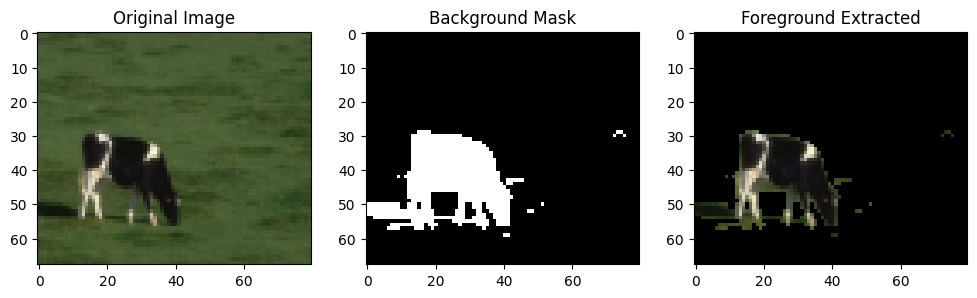

In [5]:
bg_label = np.bincount(labels).argmax()

mask = (labels != bg_label).astype(np.uint8).reshape(image.shape[:2])
mask_rgb = np.stack([mask]*3, axis=-1)
foreground = image * mask_rgb

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image)

plt.subplot(1, 3, 2)
plt.title("Background Mask")
plt.imshow(mask, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Foreground Extracted")
plt.imshow(foreground)
plt.show()